In [380]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve, plot_roc_curve, auc, precision_recall_curve

# Load Dataset

In [381]:
dataset = pd.read_csv('aug_train.csv')

In [382]:
dataset

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


Feature Description

- enrollee_id: Unique ID for candidate
- city: City code
- city_development_index: Developement index of the city (scaled)
- gender: Gender of candidate
- relevent_experience: Relevant experience of candidate
- enrolled_university: Type of University course enrolled if any
- education_level: Education level of candidate
- major_discipline: Education major discipline of candidate
- experience: Candidate total experience in years
- company_size: No of employees in current employer's company
- company_type: Type of current employer
- lastnewjob: Difference in years between previous job and current job
- training_hours: training hours completed
- target: 0 – Not looking for job change, 1 – Looking for a job change

# Data Visualization

Let's play with the data a little bit. See if we can get some insights from it.

## Missing Data

The chart below shows the percentage of non-missing data within each feature. The missing data percentage is quite significant with the max missing data up to 30%.

<AxesSubplot:>

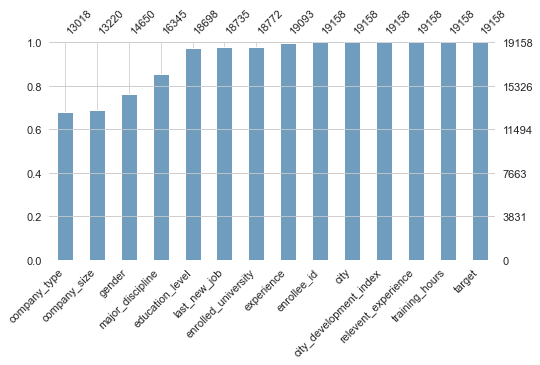

In [395]:
missingno.bar(dataset,color=(0.44, 0.61, 0.74), sort="ascending", figsize=(8,4), fontsize=11)

## Countplot and Histogram plot of individual feature

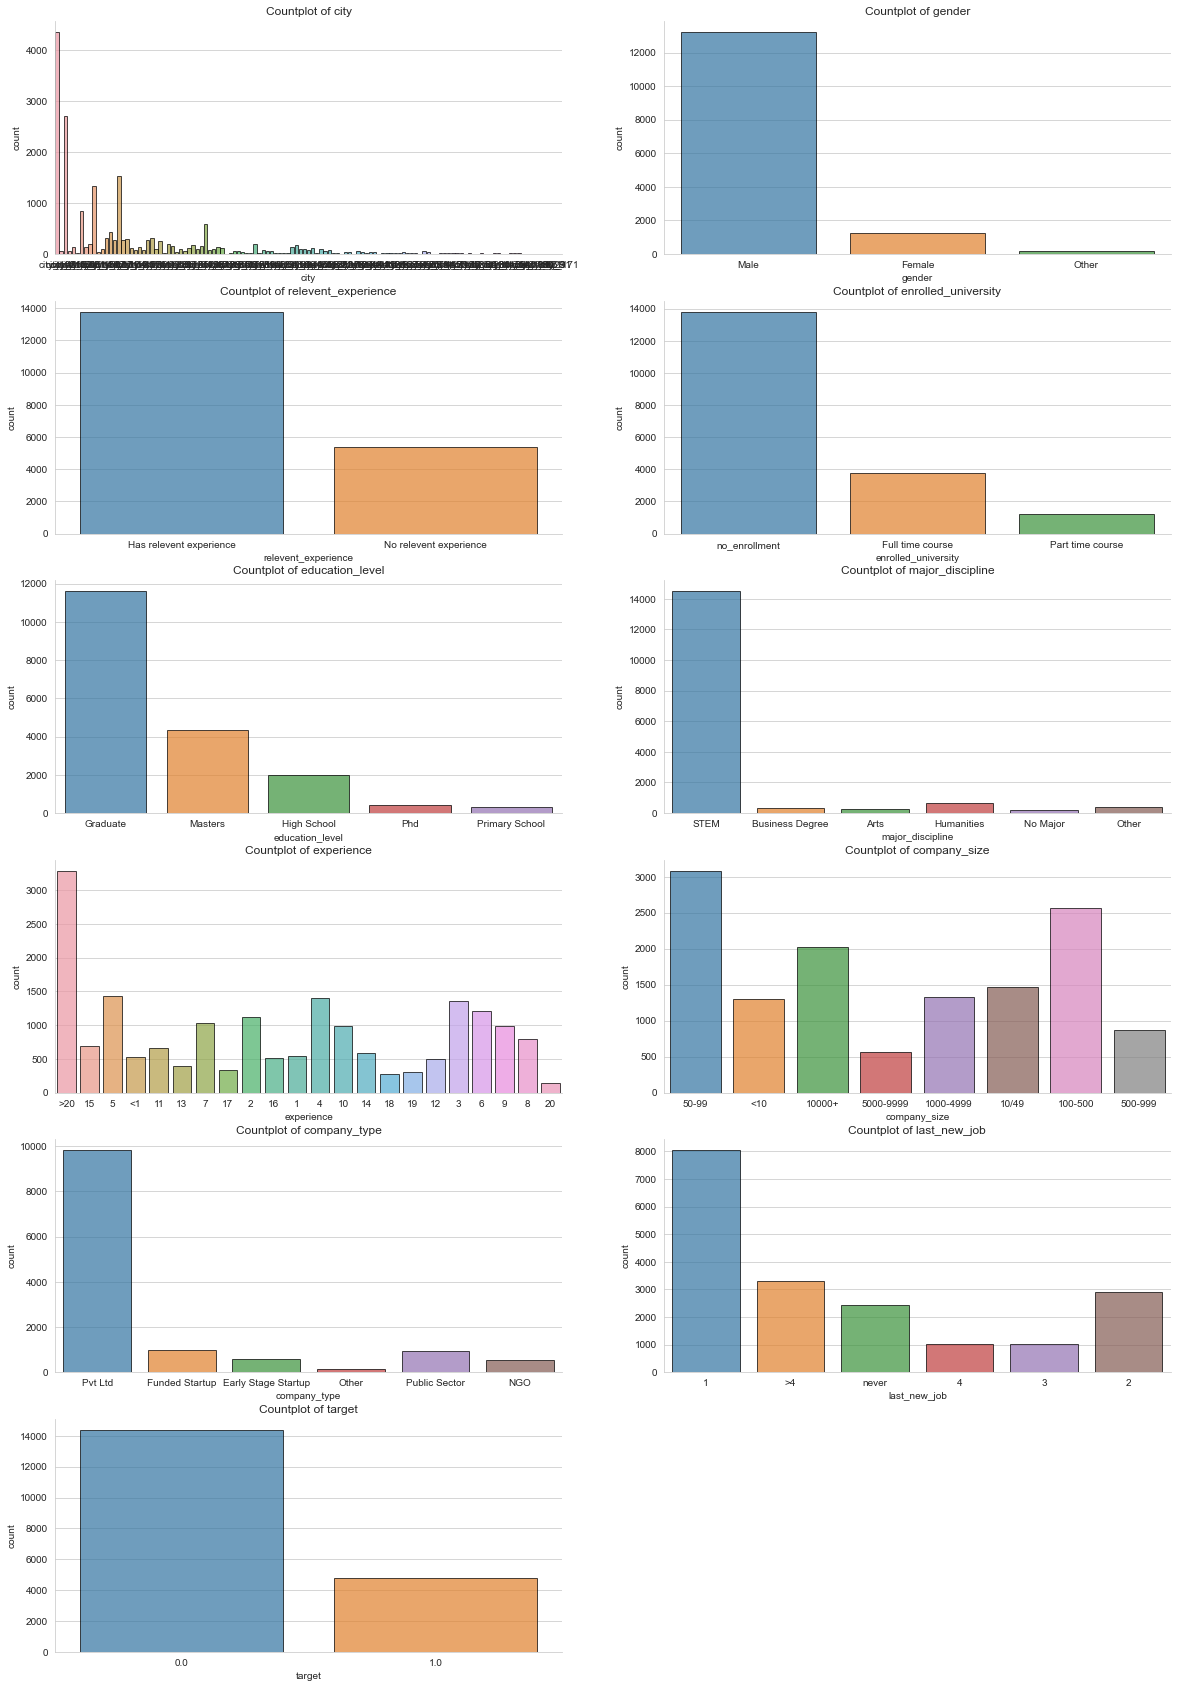

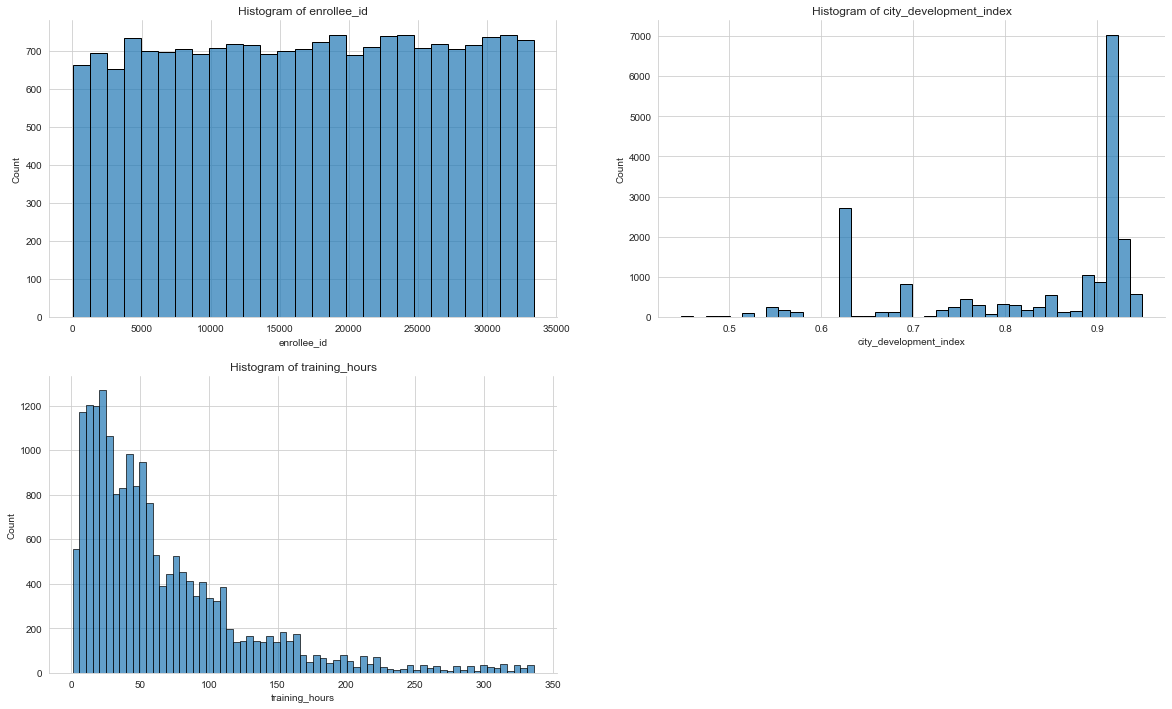

In [331]:
#barplot on categorial cols
n=1
plt.figure(figsize=[20,30])
for col in ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level',
           'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job',
           'target']:
    plt.subplot(6,2,n)
    sns.countplot(x=col, edgecolor="black", alpha=0.7,data=dataset)
    sns.despine()
    plt.title("Countplot of {}".format(col))
    n=n+1
#plt.tight_layout()
plt.show()

#histogram on numeric cols
n=1
plt.figure(figsize=[20,12])
for col in ['enrollee_id', 'city_development_index', 'training_hours']:
    plt.subplot(2,2,n)
    sns.histplot(x=col, edgecolor="black", alpha=0.7,data=dataset)
    sns.despine()
    plt.title("Histogram of {}".format(col))
    n=n+1
#plt.tight_layout()
plt.show()

## Correlations between features and target

For a first takeaway, we can tell from the 'target' countplot that the data is imbalanced. Next let's see if we can find correlations between each feature and 'target'.

### Correlations between categorical features and target

I made a function to plot the stackplot to visulize correlations between variables, since seaborn doesn't have a stackplot. 

The stackplot controls for the bias introduced by imbalanced data, because it shows groups as percentages of each target label, rather than as raw counts. Keep in mind that we still have a somewhat small sample size for target=1, so we should be cautious to make conclusions especially when interescting with other imbalanced groups (e.g. gender), because the sample size would cumulatively be quite small for some combinations (e.g. target=1 & gender=other).

For labeling, I set the threshold to a relative difference of 50%(0.5), so that labels for groups with small differences won't clutter up the plot. If you want to see more detail, you can change the if statement in the cell. This filtering will however still label groups which have
a large relative different but very small absolute size, which practically speaking may be noise. To keep the code simple, we won't filter those out, but we can just choose to ignore them when discussing correlations.

In [332]:
def stackplot(groupbyvariable, stackedvariable, figsize, haslegend):
    fig, ax = plt.subplots(figsize=figsize)
    df = dataset.groupby([groupbyvariable])[stackedvariable].value_counts(normalize=True).rename('percentage').reset_index().sort_values(groupbyvariable)
    labelsofgroupbyvariable = list(df[df[stackedvariable]==df[stackedvariable].unique()[0]][groupbyvariable])
    labels = list(map(str, labelsofgroupbyvariable))
    labels = list(map(str, df[groupbyvariable].unique()))
    legend = df[stackedvariable].unique()
    previous_bottom = np.zeros(len(labels))
    
    for x in legend:
        extracted_df = df[df[stackedvariable]==x]
        perofx = extracted_df['percentage']
        the_bars = ax.bar(labels, perofx.values, bottom=previous_bottom, label=x)
        previous_bottom = previous_bottom + perofx.values
        perodx_diff = (perofx.max() - perofx.min())/perofx.min()
        if perodx_diff > 0.5:
            #print('{}: the max and min {}% difference by {} is {}'.format(x, stackedvariable, groupbyvariable, perodx_diff))
            #turn it on to see detailed percetage difference
            ax.bar_label(the_bars, label_type='center', labels=list(map(lambda _: x, labels)))
    ax.set_ylabel('{}% within the same {}'.format(stackedvariable, groupbyvariable))
    ax.set_xlabel('{}'.format(groupbyvariable))
    ax.set_title("{}% by {}".format(stackedvariable, groupbyvariable))
    if haslegend:
        ax.legend(loc='center left', bbox_to_anchor=(1.04, 1))
    fig.tight_layout()
    plt.show()

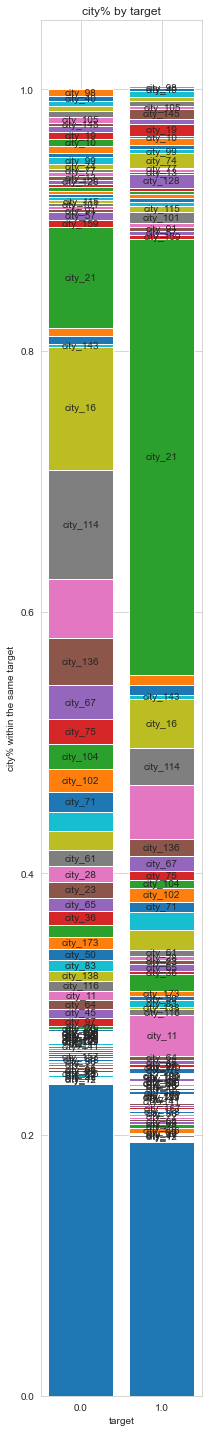

In [333]:
stackplot('target', 'city',(3,20), False)
#the legend is not shown due to limited size
#you can set the false to true if you want to see the legend

cities that are positively correlated to target 0: 
city_16, city_114, city_136, city_67, city_75, city_104, city_102, city_71

cities that are positively correlated to target 1: 
city_21, city_11

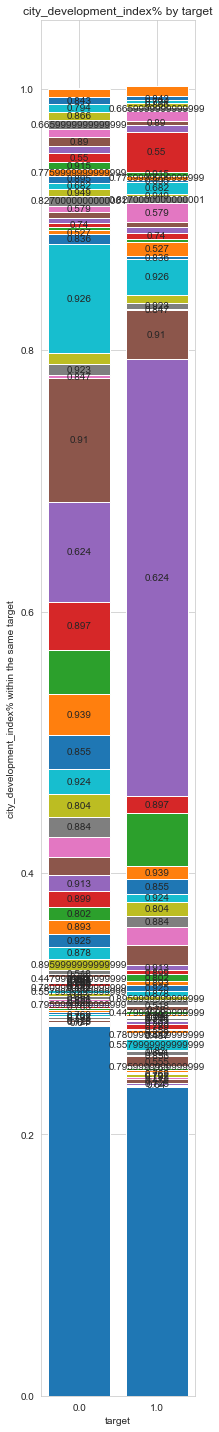

In [334]:
stackplot('target', 'city_development_index', (3,20), False)
#the same 'city_development_index' is usually matched with the same 'city', so we can treat 'city_development_index' as categorical feature here.

city_development_index that are positively correlated to target 0:
0.926(city_114), 0.91(city_16), 0.897(city_136), 0.939(city_75), 0.855(city_67), 0.924(city_104), 0.884(city_71)

city_development_index that are positively correlated to target 1:
0.55(city_11), 0.579, 0.624(city_21)

It's easy to tell high CDI is positively related to target0, whereas low CDI is positively related to target1. We can also tell city and CDI are highly correlated. We don't need to get rid of one col as catboost can handle multicollinearity within the features fine.

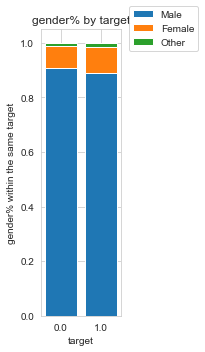

In [335]:
stackplot('target', 'gender', (3,5), True)

No significant correlation within the same gender when compared to different targets.

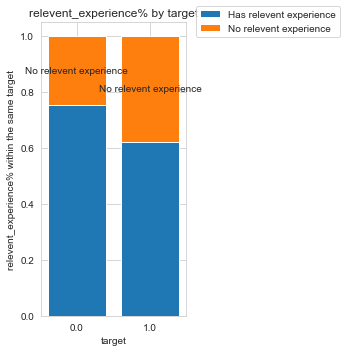

In [336]:
stackplot('target', 'relevent_experience',(5,5), True)

People with 'No relevent experience' are more likely to be target '1'(Looking for a job change). That makes sense because people with no experience want to learn enough skills from the company then apply for a better position elsewhere.

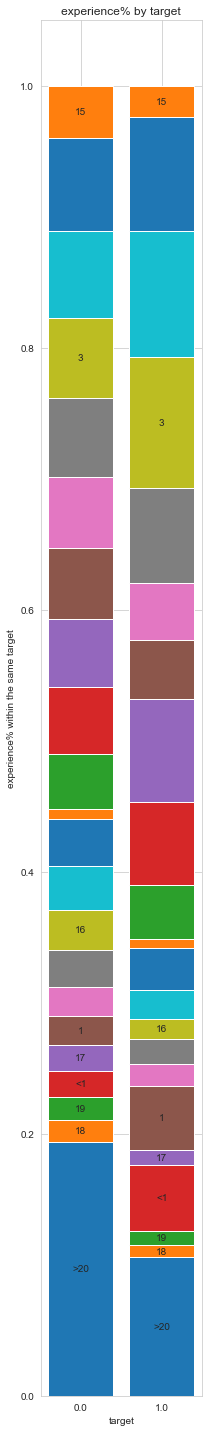

In [337]:
stackplot('target', 'experience',(3,20), False)

experience(in years) that are positively correlated to target 0:
15, 16, 17, 18, 19, >20

experience(in years) that are positively correlated to target 1:
<1, 1, 3

More experienced people are more likely to not change the job(target 0), whereas less experienced people are more likely to change the job(target 1), which also makes sense.

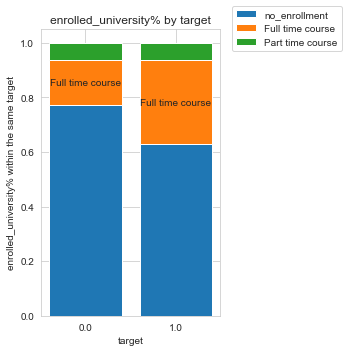

In [338]:
stackplot('target', 'enrolled_university', (5,5), True)

People enrolled in 'full time course' are more likely looking for a job change(target 1).

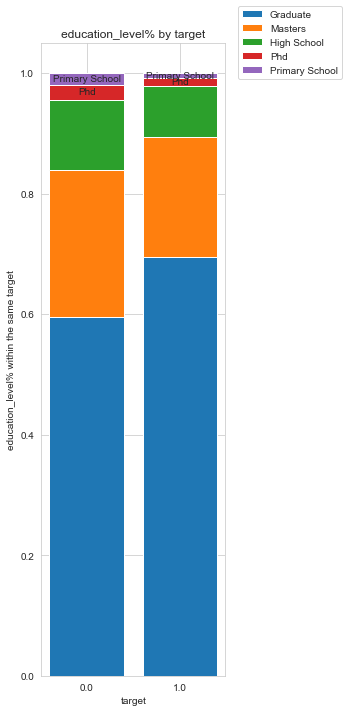

In [339]:
stackplot('target', 'education_level', (5,10), True)

People with education level Phd or Primary School are more likely not looking for a job change(target 0)

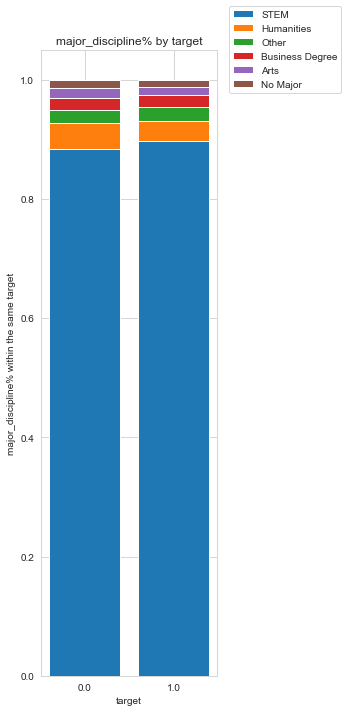

In [340]:
stackplot('target', 'major_discipline', (5,10), True)

No significant correlation within the same 'major_discipline' when compared to different targets.

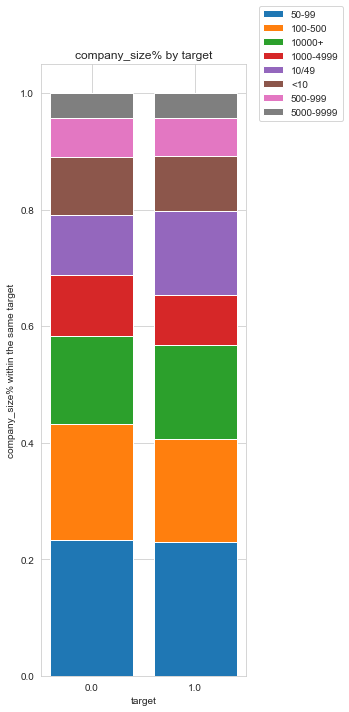

In [341]:
stackplot('target', 'company_size', (5,10), True)

No significant correlation within the same 'company_size' when compared to different targets.

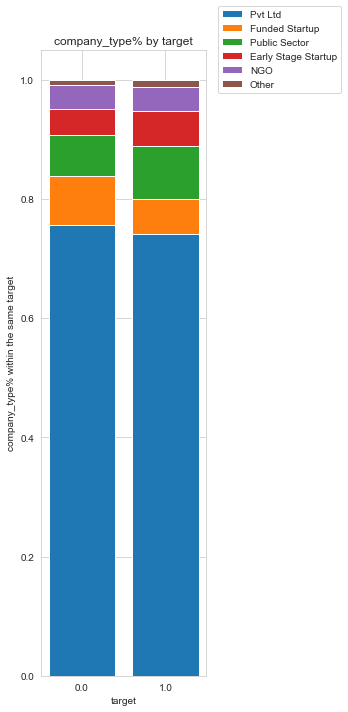

In [342]:
stackplot('target', 'company_type', (5,10), True)

No significant correlation within the same 'company_type' when compared to different targets.

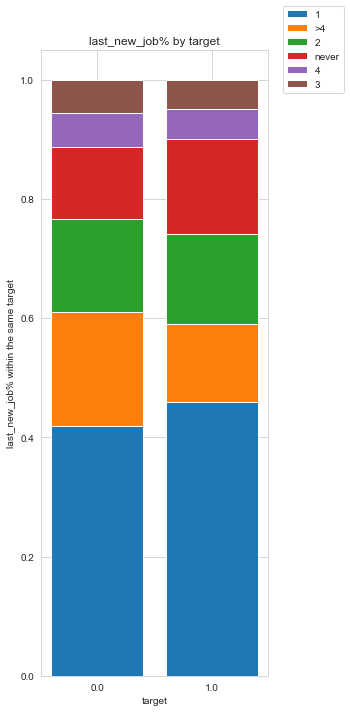

In [343]:
stackplot('target', 'last_new_job', (5,10), True)

No significant correlation within the same 'last_new_job' when compared to different targets.

### Correlations between numerical features and target

#### Visulize the correlations using Violin Plot

> A violin plot plays a similar role as a box and whisker plot. It shows the distribution of quantitative data across several levels of one (or more) categorical variables such that those distributions can be compared. Unlike a box plot, in which all of the plot components correspond to actual datapoints, the violin plot features a kernel density estimation of the underlying distribution.

(See [seaborn violin plot doc](https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot)).

Note not to read into the different distributions among the violins too much, due to the influence of sample size.

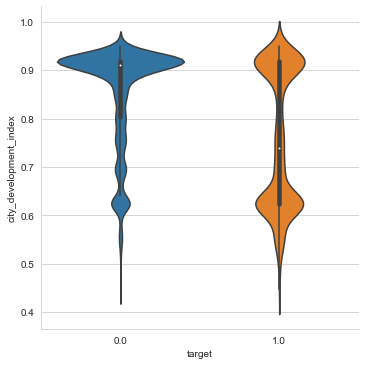

In [344]:
sns.catplot(x="target", y="city_development_index",
            kind="violin", split=True, data=dataset)

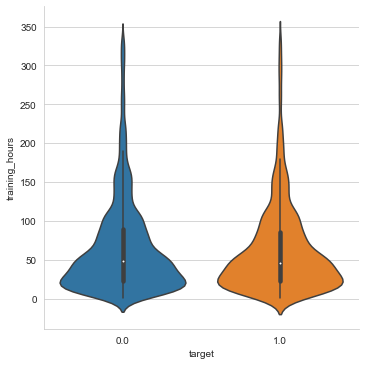

In [345]:
sns.catplot(x="target", y="training_hours",
            kind="violin", split=True, data=dataset)

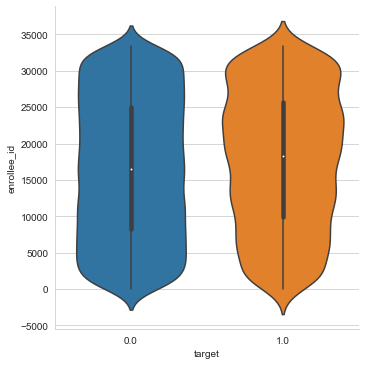

In [346]:
sns.catplot(x="target", y="enrollee_id",
            kind="violin", split=True, data=dataset)

#### Calculate the correlation

Here I tried to measure correlation in data using Correlation coefficients.

Correlation coefficients are used to measure how strong a relationship is between two variables.  The coefficients are values between -1 and 1, where:
 
* 1 indicates a strong positive relationship.
* -1 indicates a strong negative relationship.
* A result of zero indicates no relationship at all.

In [347]:
corr=dataset.corr()["target"]
corr[np.argsort(corr, axis=0)[:-1]]

city_development_index   -0.341665
training_hours           -0.021577
enrollee_id               0.049475
Name: target, dtype: float64

The correlation coefficients match the violin plots above

## Visualize correlations between more than one feature and target using Violin Plot

### gender, cdi, target

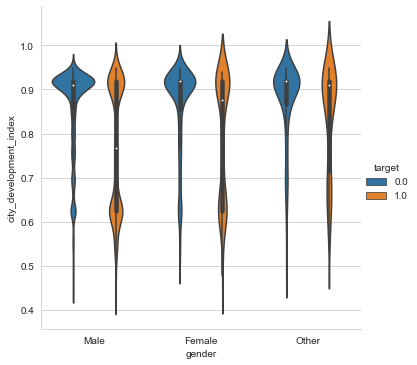

In [348]:
sns.catplot(x="gender", y="city_development_index", hue='target',
            kind="violin", split=False, data=dataset, scale="area", scale_hue=False)
#The area of each violin is set to the same by 'scale="area", scale_hue=False'

### gender, training_hours, target

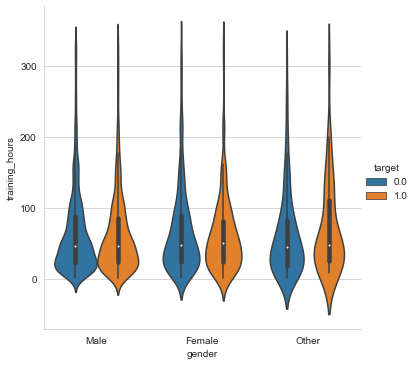

In [349]:
sns.catplot(x="gender", y="training_hours", hue='target',
            kind="violin", split=False, data=dataset, scale="area", scale_hue=False)

### gender, enrollee_id, target

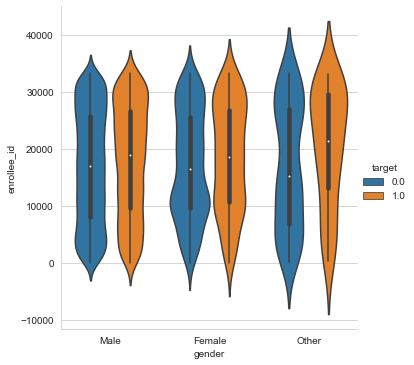

In [350]:
sns.catplot(x="gender", y="enrollee_id", hue='target',
            kind="violin", split=False, data=dataset, scale="area", scale_hue=False)

### relevent_experience, cdi, target

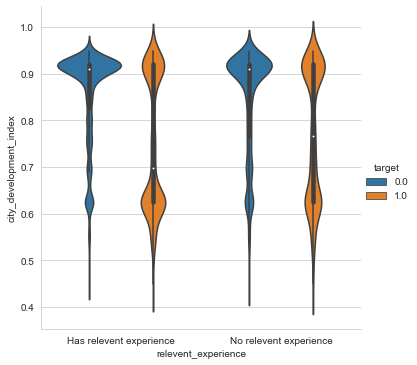

In [351]:
sns.catplot(x="relevent_experience", y="city_development_index", hue='target',
            kind="violin", split=False, data=dataset, scale="area", scale_hue=False)

### relevent_experience, training_hours, target

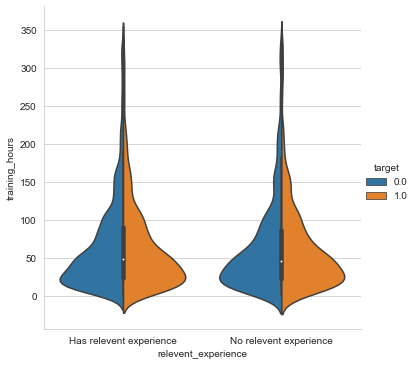

In [352]:
sns.catplot(x="relevent_experience", y="training_hours", hue='target',
            kind="violin", split=True, data=dataset, scale="area", scale_hue=False)

### relevent_experience, enrollee_id, target

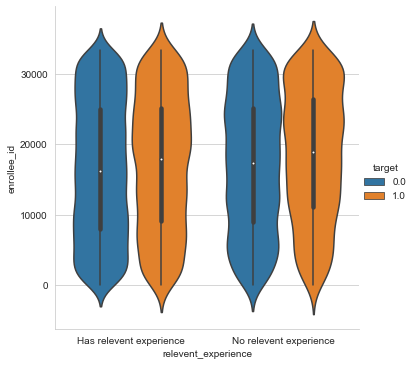

In [353]:
sns.catplot(x="relevent_experience", y="enrollee_id", hue='target',
            kind="violin", split=False, data=dataset, scale="area", scale_hue=False)

### enrolled_university, cdi, target

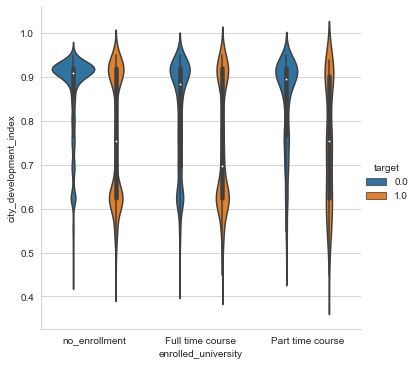

In [354]:
sns.catplot(x="enrolled_university", y="city_development_index", hue='target',
            kind="violin", split=False, data=dataset, scale="area", scale_hue=False)
#sns.violinplot(x="enrolled_university", y="city_development_index", hue='target', split=False, data=dataset, scale="count")

### enrolled_university, training_hours, target

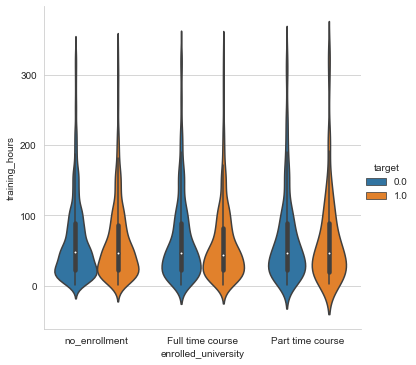

In [355]:
sns.catplot(x="enrolled_university", y="training_hours", hue='target',
            kind="violin", split=False, data=dataset, scale="area", scale_hue=False)

### enrolled_university, enrollee_id, target

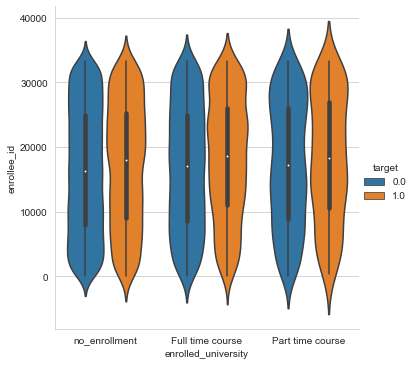

In [356]:
sns.catplot(x="enrolled_university", y="enrollee_id", hue='target',
            kind="violin", split=False, data=dataset, scale="area", scale_hue=False)

### education_level, cdi, target

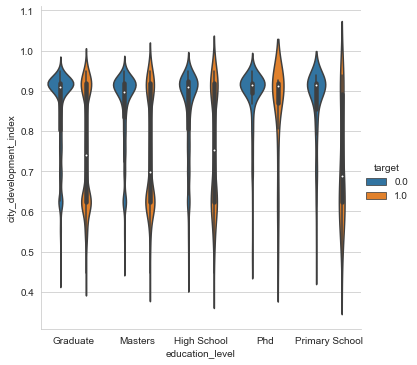

In [357]:
sns.catplot(x="education_level", y="city_development_index", hue='target',
            kind="violin", split=False, data=dataset, scale="area", scale_hue=False)

### education_level, training_hours, target

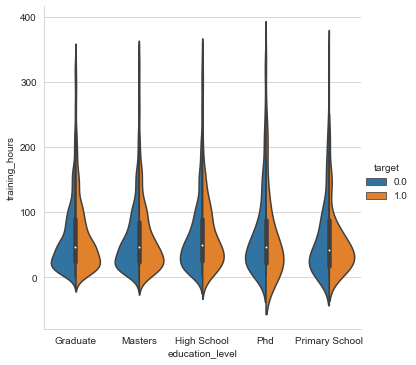

In [358]:
sns.catplot(x="education_level", y="training_hours", hue='target',
            kind="violin", split=True, data=dataset, scale="area", scale_hue=False)

### education_level, enrollee_id, target

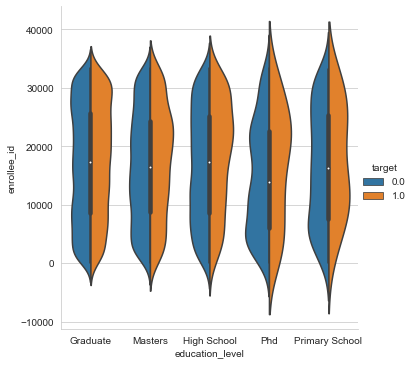

In [359]:
sns.catplot(x="education_level", y="enrollee_id", hue='target',
            kind="violin", split=True, data=dataset, scale="area", scale_hue=False)

# Data Preprocessing

In [360]:
x = dataset.iloc[:, 0:13].copy()#
y = dataset.iloc[:, -1]

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

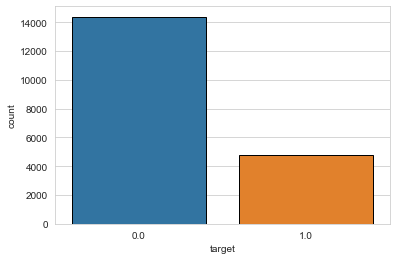

In [361]:
import seaborn as sns
sns.set_style('whitegrid')
sns.countplot(y, edgecolor = 'black')

## Label encode categorical data

We can tell the data is very imbalanced here, so we will use SMOTE to generate more data. Before using SMOTE, I want to use KNN to impute missing data. Before doing KNN, we need to label encode the categorical data, as KNN only takes numeric data.

In [362]:
from sklearn.preprocessing import LabelEncoder
list_of_lbl_enc=[]

for col in x[['city','gender', 'relevent_experience', 'enrolled_university', 'education_level',
             'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']]:
    lbl_enc = LabelEncoder()
    #print(col)
    col_level_series_transformed = pd.Series(
        lbl_enc.fit_transform(x[col][x[col].notnull()]),
        index=x[col][x[col].notnull()].index)
    x[col] = col_level_series_transformed
    list_of_lbl_enc.append(lbl_enc)
    #print(col, list(lbl_enc.classes_))
    #print()
    #print(x[col].value_counts())
#print(list_of_lbl_enc)

## Split the dataset into training set and testing set

The data should be split before doing any KNN imputation or SMOTE, so it doesn't introduce any 'made up' data into the testing set.

In [363]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1) 

## Impute missing data using KNNImputer

In [364]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=3) 
x_train = knn_imputer.fit_transform(x_train)
x_test = knn_imputer.transform(x_test)

In [365]:
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

In [366]:
#round imputed categorical features
x_train[[1,3,4,5,6,7,8,9,10,11]] = np.rint(x_train.iloc[:, [1,3,4,5,6,7,8,9,10,11]]).astype(int)
x_test[[1,3,4,5,6,7,8,9,10,11]] = np.rint(x_test.iloc[:, [1,3,4,5,6,7,8,9,10,11]]).astype(int)

In [367]:
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

To generate more data, I will use SMOTENC which takes in categorical features, so the data need to be inverse transformed into categorical data

In [368]:
i=0
for col in [1,3,4,5,6,7,8,9,10,11]:
    lbl_enc = list_of_lbl_enc[i]
    x_train.iloc[:,col] = lbl_enc.inverse_transform(x_train.iloc[:,col])
    x_test.iloc[:,col] = lbl_enc.inverse_transform(x_test.iloc[:,col])
    i=i+1
print(x_train)

            0         1      2     3                        4   \
0       3824.0  city_103  0.920  Male  Has relevent experience   
1      19023.0   city_21  0.624  Male  Has relevent experience   
2      15046.0  city_103  0.920  Male  Has relevent experience   
3       9842.0   city_16  0.910  Male  Has relevent experience   
4      10294.0   city_21  0.624  Male  Has relevent experience   
...        ...       ...    ...   ...                      ...   
15321  24633.0  city_160  0.920  Male  Has relevent experience   
15322  15042.0  city_128  0.527  Male  Has relevent experience   
15323  27600.0   city_57  0.866  Male   No relevent experience   
15324   8162.0   city_61  0.913  Male  Has relevent experience   
15325    405.0  city_165  0.903  Male  Has relevent experience   

                     5            6         7    8        9              10  \
0         no_enrollment      Masters      STEM  >20   10000+  Public Sector   
1         no_enrollment     Graduate      STEM   

## Generate data using SMOTENC

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

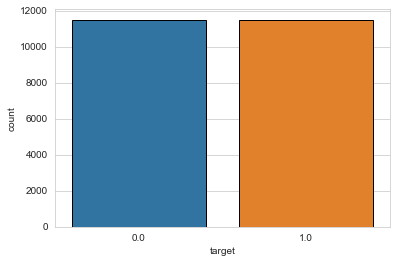

In [369]:
#generate more data
from imblearn.over_sampling import SMOTENC
smote_nc = SMOTENC(categorical_features=[1,3,4,5,6,7,8,9,10,11], random_state = 0)
x_smote, y_smote = smote_nc.fit_resample(x_train,y_train)
sns.countplot(y_smote, edgecolor = 'black')

In [370]:
x_train = x_smote
y_train = y_smote

I also tried doing some dimensionality reduction including PCA, KPCA, LDA, but they don't seem to help much, so I didn't keep the code.

# Training with Catboost and hyperparameter tuning using Bayesian optimization with gaussian process

Following the Catboost documentation on [number of trees](https://catboost.ai/docs/concepts/parameter-tuning.html#trees-number)("It is recommended to check that there is no obvious underfitting or overfitting before tuning any other parameters. In order to do this it is necessary to analyze the metric value on the validation dataset and select the appropriate number of iterations."), I set the eval_metric to 'AUC' to manually find the best iterations.

In [371]:
from catboost import CatBoostClassifier, Pool
cat_features = [1,3,4,5,6,7,8,9,10,11]
classifier_catboost = CatBoostClassifier(iterations=1000, use_best_model=True, eval_metric='AUC')
eval_dataset = Pool(x_test,
                    y_test,cat_features)
classifier_catboost.fit(x_train,
          y_train,cat_features,
          eval_set=eval_dataset,
          verbose=True)
print(classifier_catboost.get_best_iteration())

Learning rate set to 0.068743
0:	test: 0.7281219	best: 0.7281219 (0)	total: 53.9ms	remaining: 53.8s
1:	test: 0.7388207	best: 0.7388207 (1)	total: 106ms	remaining: 53.1s
2:	test: 0.7439465	best: 0.7439465 (2)	total: 138ms	remaining: 45.9s
3:	test: 0.7415131	best: 0.7439465 (2)	total: 178ms	remaining: 44.3s
4:	test: 0.7387313	best: 0.7439465 (2)	total: 228ms	remaining: 45.3s
5:	test: 0.7363080	best: 0.7439465 (2)	total: 288ms	remaining: 47.7s
6:	test: 0.7373641	best: 0.7439465 (2)	total: 320ms	remaining: 45.4s
7:	test: 0.7374941	best: 0.7439465 (2)	total: 361ms	remaining: 44.7s
8:	test: 0.7401561	best: 0.7439465 (2)	total: 389ms	remaining: 42.9s
9:	test: 0.7431610	best: 0.7439465 (2)	total: 422ms	remaining: 41.8s
10:	test: 0.7411983	best: 0.7439465 (2)	total: 458ms	remaining: 41.1s
11:	test: 0.7423423	best: 0.7439465 (2)	total: 510ms	remaining: 42s
12:	test: 0.7427896	best: 0.7439465 (2)	total: 543ms	remaining: 41.3s
13:	test: 0.7432695	best: 0.7439465 (2)	total: 571ms	remaining: 40.2s
1

Turns out the best is 372, so we will use iterations = 372 for the following tuning.

## Hyperparam Tuning (Bayesian optimization with gaussian process)

In [372]:
def pipeline(params, param_names, x_train, y_train, x_test, y_test):
    # convert params to dictionary
    params = dict(zip(param_names, params))

    catboost_param_names = ['learning_rate', 'depth', 'l2_leaf_reg', 'random_strength', 'bagging_temperature', 'border_count']
    catboost_params = {param_name: params[param_name] for param_name in params if param_name in catboost_param_names}
    knn_params = {param_name: params[param_name] for param_name in params if param_name not in catboost_param_names}
    
    # initialize model with current parameters
    knn_imputer = KNNImputer(**knn_params)
    classifier_catboost = CatBoostClassifier(iterations=32, verbose=False, **catboost_params)
    
    x_train = knn_imputer.fit_transform(x_train)
    x_test = knn_imputer.transform(x_test)
    
    x_train = pd.DataFrame(x_train)
    x_test = pd.DataFrame(x_test)
    
    x_train[[1,3,4,5,6,7,8,9,10,11]] = np.rint(x_train.iloc[:, [1,3,4,5,6,7,8,9,10,11]]).astype(int)
    x_test[[1,3,4,5,6,7,8,9,10,11]] = np.rint(x_test.iloc[:, [1,3,4,5,6,7,8,9,10,11]]).astype(int)
        
    x_train = pd.DataFrame(x_train)
    x_test = pd.DataFrame(x_test)
    
    a=0
    for col in [1,3,4,5,6,7,8,9,10,11]:
        lbl_enc = list_of_lbl_enc[a]
        x_train.iloc[:,col] = lbl_enc.inverse_transform(x_train.iloc[:,col])
        x_test.iloc[:,col] = lbl_enc.inverse_transform(x_test.iloc[:,col])
        a=a+1

    smote_nc = SMOTENC(categorical_features=[1,3,4,5,6,7,8,9,10,11], random_state = 0)
    x_train_smote, y_train_smote = smote_nc.fit_resample(x_train,y_train)


    #fit model
    cat_features = [1,3,4,5,6,7,8,9,10,11]
    classifier_catboost.fit(x_train_smote,y_train_smote,cat_features)

    y_pred_train = classifier_catboost.predict_proba(x_train)
    y_pred_train_pos = y_pred_train[:,1]
    
    y_pred_test = classifier_catboost.predict_proba(x_test)
    y_pred_test_pos = y_pred_test[:,1]
    
    return y_pred_train_pos, classifier_catboost.predict(x_train), y_pred_test_pos, classifier_catboost.predict(x_test)

In [373]:
#Bayesian optimization algorithm need a function they can optimize. 
#Most of the time, it’s about the minimization of this function, like we minimize loss.
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve, plot_roc_curve, auc, precision_recall_curve

def optimize(params, param_names, x, y):
    # initialize stratified k fold
    kf = StratifiedKFold(n_splits = 5)
    
    i = 0
    
    # initialize auc scores list
    auc_scores = []
    
    #loop over all folds
    for index in kf.split(X = x, y = y): 
        #split generate indices to split data into training and test set.
        train_index, test_index = index[0], index[1]
        
        x_train = x.iloc[train_index,:]
        y_train = y[train_index]
        
        x_test = x.iloc[test_index,:]
        y_test = y[test_index]
        
        _, _, y_pred_test_pos, _ = pipeline(params, param_names, x_train, y_train, x_test, y_test)
        
        auc = roc_auc_score(y_test, y_pred_test_pos)
        print(f'Current parameters of fold number {i} -> {params}')
        print(f'AUC score of test {i} f {auc}')

        i = i+1
        auc_scores.append(auc)
        
    return -1 * np.mean(auc_scores)
    

I turned off the training bc it took hours to train, but the hyperparam combo which gives the best test AUC score is : {'learning_rate': 0.26303264462846715, 'depth': 3, 'l2_leaf_reg': 10.0, 'random_strength': -10.0, 'bagging_temperature': 0.1968690337194276, 'border_count': 254, 'n_neighbors': 8, 'weights': 'uniform'}. 

I only did n_calls = 20, we can keep going further to set the n_calls to be a bigger number, but I will keep going with the best I got due to limited time.

In [374]:
#define a parameter space
# from skopt import space, gp_minimize
# from functools import partial
# param_spaces = [space.Real(0.0001, 0.47, name = 'learning_rate'),
#                 space.Integer(3, 11, name = 'depth'),
#                 space.Real(0, 10, name = 'l2_leaf_reg'),
#                 space.Real(-10,10, name = 'random_strength'),
#                 space.Real(0,2, name = 'bagging_temperature'),
#                 space.Integer(254, 300, name = 'border_count'),
#                 space.Integer(1, 10, name = 'n_neighbors'),
#                 space.Categorical(['uniform', 'distance'], transform='identity', name='weights')
# ]

# # make a list of param names this has to be same order as the search space inside the main function
#param_names = ['learning_rate', 'depth', 'l2_leaf_reg', 'random_strength', 'bagging_temperature', 'border_count', 'n_neighbors', 'weights']

# # by using functools partial, i am creating a new function which has same parameters as the optimize function except 
# # for the fact that only one param, i.e. the "params" parameter is required. 
# # This is how gp_minimize expects the optimization function to be. 

# optimize_function = partial(optimize, param_names = param_names, x = x, y = y)
# result = gp_minimize(optimize_function, dimensions = param_spaces, n_calls = 20, n_random_starts = 5, verbose = True)

In [375]:
best_params = {'learning_rate': 0.26303264462846715, 'depth': 3, 'l2_leaf_reg': 10.0, 'random_strength': -10.0, 'bagging_temperature': 0.1968690337194276, 'border_count': 254, 'n_neighbors': 8, 'weights': 'uniform'}
param_names = ['learning_rate', 'depth', 'l2_leaf_reg', 'random_strength', 'bagging_temperature', 'border_count', 'n_neighbors', 'weights']
result_x = [best_params[pn] for pn in param_names]

In [376]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1) 

y_pred_train_pos, y_pred_train, y_pred_test_pos, y_pred_test = pipeline(result_x, param_names, x_train, y_train, x_test, y_test)

In [377]:
def plot_auc_curve(fpr, tpr, auc, title_prefix=''):
    plt.figure(figsize = (16,6))
    plt.plot(fpr,tpr,'b+',linestyle = '-')
    plt.fill_between(fpr, tpr, alpha = 0.5)
    plt.ylabel('True Postive Rate')
    plt.xlabel('False Postive Rate')
    plt.title(f'{title_prefix}ROC Curve Having AUC = {auc}')

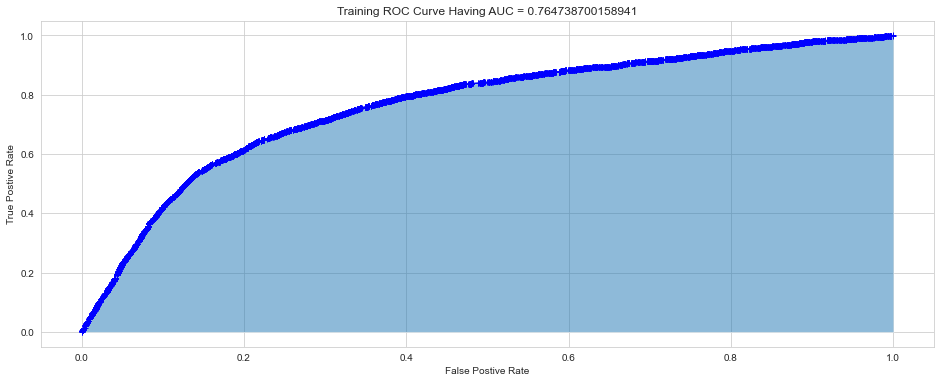

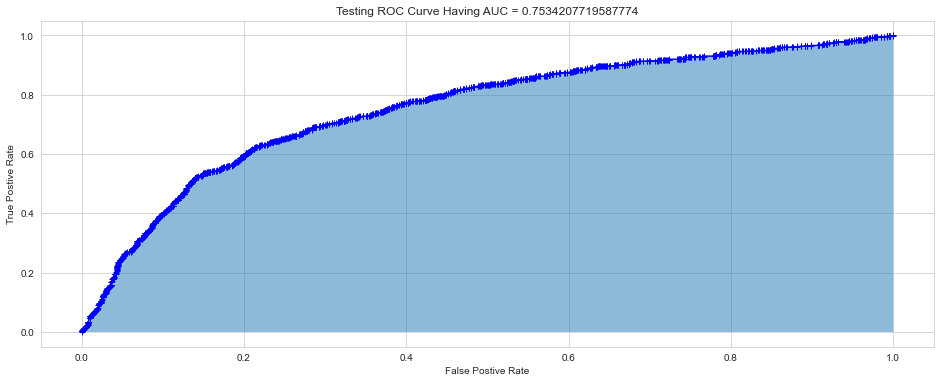

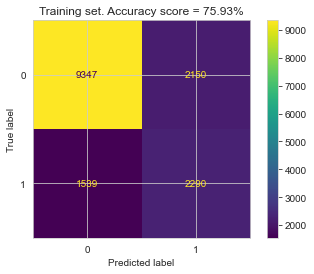

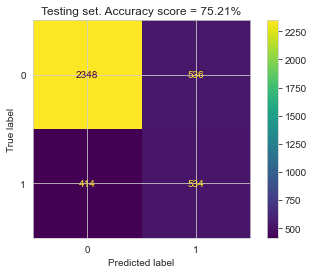

In [397]:
# Training ROC
auc_train = roc_auc_score(y_train, y_pred_train_pos)
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train_pos)
plot_auc_curve(fpr_train, tpr_train, auc_train, 'Training ')

# Testing ROC
auc_test = roc_auc_score(y_test, y_pred_test_pos)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test_pos)
plot_auc_curve(fpr_test, tpr_test, auc_test, 'Testing ')


# Training confusion matrix
cm_train = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_train)
disp.plot()
disp.ax_.set_title('Training set. Accuracy score = {:.2%}'.format(accuracy_score(y_train, y_pred_train)))
plt.show()

# Testing confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_test)
disp.plot()
disp.ax_.set_title('Testing set. Accuracy score = {:.2%}'.format(accuracy_score(y_test, y_pred_test)))
plt.show()

The result is shown not overfitted. 